# Introduction to Neural Networks - MicroTorch


Neural networks are a core component of deep learning, driving advancements in image recognition, natural language processing, robotics, and more. These networks are made up of interconnected layers that transform data through a series of operations, allowing them to learn complex patterns. At the heart of neural networks is the process of learning through gradients, calculated by *backpropagation* and the *chain rule*, which enables the network to adjust its parameters based on how much each parameter contributes to the overall error.

Modern deep learning frameworks like **PyTorch** and **TensorFlow** provide powerful abstractions for building and training neural networks, automatically handling gradient calculations and optimization steps. However, to truly understand how neural networks learn, it’s invaluable to implement the core components from scratch, gaining insight into the inner workings of backpropagation.

In this assignment, we will build a mini neural network framework that supports gradient propagation, allowing us to train a network on a real task and observe how it learns. Specifically, you will **implement a Neural Network from Scratch using MicroTorch**: Develop a simple neural network framework with core operations like linear transformations, activation functions, and loss calculations. Implement backpropagation and a training loop to optimize network parameters.

**Notes:**
- We've provided all the imports that you'll need for this assignment, though you're welcome to add imports _from the Python Standard Library only_ if you need them. If you want to add any helper functions for whatever reason, please make sure that they are nested inside the function that they are used in. This is to ensure that the autograder can run your code without any issues.
- ***DO NOT REMOVE ANY COMMENTS THAT HAVE `# export` IN THEM. THE GRADING SCRIPT USES THESE COMMENTS TO EVALUATE YOUR FUNCTIONS. WE WILL NOT AUDIT SUBMISSIONS TO ADD THESE. IF THE AUTOGRADER FAILS TO RUN DUE TO YOUR MODIFICATION OF THESE COMMENTS, YOU WILL NOT RECEIVE CREDIT.***


# Installations

In [784]:
%pip install numpy
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [785]:
# export - DO NOT MODIFY THIS CELL
# General imports
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from helpers import plot_loss

In [786]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# add any additional imports here (from the Python Standard Library only!)

# Neural Networks in MicroTorch


## MicroTorch Overview

In this section, you’ll build a mini neural network framework called **MicroTorch**. This framework mimics some of the core functionalities of PyTorch but at a much simpler level. The goal of MicroTorch is to give you hands-on experience with backpropagation, gradient chaining, and parameter updates, helping you understand the underlying mechanics of a neural network without relying on a high-level framework.

### Why Build MicroTorch?

Modern deep learning frameworks, such as PyTorch and TensorFlow, handle computations and backpropagation automatically by creating **computation chains**. In PyTorch, each `Tensor` object keeps track of operations applied to it, forming a chain of computations that allows automatic gradient calculation via **automatic differentiation**.

MicroTorch takes a slightly different approach. Instead of tracking operations in `Tensor` objects, each **module** (or layer) in MicroTorch will track its own inputs, outputs, and gradients. This simplified approach allows us to implement chaining through the modules themselves, making it easier to see how data flows through the network and how gradients are propagated backward.

### How MicroTorch Works

Each module in MicroTorch will keep track of:
- **Inputs** (`self._in`): The data it received from the previous layer.
- **Outputs** (`self._out`): The results it produced.
- **Gradients** (`self._delta`): The computed gradients during the backward pass.

By structuring MicroTorch in this way, we can implement the forward and backward passes manually, capturing inputs, outputs, and gradients at each layer. This approach lacks the optimization and scalability features of frameworks like PyTorch, but it provides valuable insight into how neural networks work under the hood.

With MicroTorch, you'll:
1. Implement custom layers and activation functions.
2. Chain modules together to form a complete neural network.
3. Train the network by manually calculating gradients and updating parameters.

Let's dive into building MicroTorch and understanding each step in detail!

## Abstract Base Classes

### Module Base Class

In MicroTorch, all layers and loss functions will inherit from a base class called `Module`. The `Module` class defines the basic structure and functionality that every layer or criterion (loss function) in our network will share.

Each `Module` has the following attributes:
- `parameters`: This will store the weights and biases for layers that require them.
- `_in`: Stores the inputs to the layer, which are essential for calculating gradients in the backward pass.
- `_out`: Stores the outputs from the layer after the forward pass.
- `_delta`: Stores the gradients (deltas) computed during the backward pass.

The `Module` class also includes these core methods:
- `forward(x)`: Defines the computation for the forward pass, taking input `x`.
- `backward(delta)`: Defines the computation for the backward pass, using `delta` from the next layer.
- `update(lr)`: Updates the parameters (if they exist) using the learning rate `lr`.

This base class simplifies the creation of new layers by ensuring they have a standard structure. Let's look at the implementation:

In [787]:
class Module:
    def __init__(self):
        self.parameters = None  # Module parameters stored here
        self._delta = None  # Gradients saved from chaining backward()
        self._out = None  # Outputs of forward() saved for chaining
        self._in = None  # Inputs to forward() saved for chaining

    # Call to run the module during the forward pass
    # x is the numpy array containing (batched) inputs
    def forward(self, x):
        pass

    # Call to run the module during the backward pass
    # Delta is the gradient from the previous module's backward call.
    def backward(self, delta=1.0):
        pass

    # Call to update parameters
    # lr is the learning rate
    def update(self, lr):
        if self.parameters is not None:
            self.parameters = self.parameters - (lr * np.dot(self._in.T, self._delta))

    # This makes it so that the object reference be called like a function.
    # When doing so, the forward function is automatically called.
    def __call__(self, x):
        return self.forward(x)

### Criterion Base Class

The `Criterion` class is a specialized type of `Module` used for defining loss functions. Like `Module`, `Criterion` has a `forward` and `backward` function, but with slight differences:
- The `forward` function now takes two arguments: `y_hat` (the predictions) and `y` (the target values). This allows it to compute the loss between the predicted and actual outputs.
- The `backward` function will calculate the gradient of the loss with respect to the predictions `y_hat`.

This setup ensures a consistent structure for all loss functions, making it easy to add custom loss criteria as needed.

In [788]:
class Criterion(Module):
    def __init__(self):
        super(Criterion, self).__init__()
        self._target = None  # Remember the target when forward is called

    # The forward function now takes two inputs:
    # y_hat is the prediction to be compared against the target
    # y is the target
    def forward(self, y_hat, y):
        pass

    # This makes it so that the object reference be called like a function.
    # When doing so, the forward function is automatically called.
    def __call__(self, x, y):
        return self.forward(x, y)

### Wrapper Functions for Forward and Backward Passes

In MicroTorch, we will use **wrapper functions** to automatically capture and store inputs, outputs, and gradients during the forward and backward passes. This simplifies the process of chaining operations and makes sure the necessary information is stored in each layer without adding extra code in every function.

**Why Use Wrapper Functions?**

In PyTorch, each `Tensor` object keeps track of operations applied to it, so chaining and gradient tracking happen automatically. However, in MicroTorch, we’re using regular numpy arrays, so we need to store this information manually. Wrappers ensure that every `forward` and `backward` function automatically saves the required values in each module.

**Example Usage**

To apply a wrapper, we use a [**decorator**](https://www.geeksforgeeks.org/decorators-in-python/) notation (example below):



```python
class MicroTorchLayer(Module):
  @layer_forward_wrapper
  def forward(self, x):
    return some_operation_on_x

  @layer_backward_wrapper
  def backward(self, delta):
    return delta * gradient_of_forward
```



In [789]:
# export - DO NOT MODIFY THIS CELL
# Put this decorator on any forward function for layer modules
def layer_forward_wrapper(fn):
    def wrapper(*args, **kwargs):
        # The module is the first argument
        module = args[0]
        # The input is the second argument. Store it in the module
        module._in = args[1]
        result = fn(*args, **kwargs)
        # Store the result of the forward function in the module
        module._out = result
        return result

    return wrapper


# Put this decorator on any backward function for layer modules
def layer_backward_wrapper(fn):
    def wrapper(*args, **kwargs):
        # The module is the first argument
        module = args[0]
        # The delta is the second argument. Store it in the module
        module._delta = args[1]
        result = fn(*args, **kwargs)
        return result

    return wrapper


# Put this decorator on any forward function for layer modules
def criterion_forward_wrapper(fn):
    def wrapper(*args, **kwargs):
        # The module is the first argument
        module = args[0]
        # The input (y_hat) is the second argument. Store it in the module
        module._in = args[1]
        # The target (y) is the third argument. Store it in the module
        module._target = args[2]
        result = fn(*args, **kwargs)
        # Store the result of the backward function in the module
        module._out = result
        return result

    return wrapper


# Put this decorator on any backward function for criterion modules
def criterion_backward_wrapper(fn):
    def wrapper(*args, **kwargs):
        # The module is the first argument
        module = args[0]
        # The delta is the second argument. Store it in the module
        module._delta = args[1]
        result = fn(*args, **kwargs)
        return result

    return wrapper

## Criterion Modules

Now let’s start by implementing our first MicroTorch modules. We’ll begin with two basic loss criterions: Mean Squared Error (MSE) and Cross-Entropy Loss.

### MSE Class

The **Mean Squared Error (MSE)** loss is one of the most common loss functions used for regression tasks. It calculates the average squared difference between predicted and actual values, making it useful for measuring the distance between predictions and targets.

**Forward Pass**

In the forward pass, the MSE function computes the loss using:
$$
L(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$
where:
- $ \hat{y}$ is the predicted value,
- $ y$ is the target value,
- $ n$ is the number of samples.

**Note:** The input to MSE loss is batched, so you should return the average loss across the batch.

**Backward Pass**

In the backward pass, the gradient of the loss with respect to the predictions is calculated as:
$$
\frac{\partial L}{\partial \hat{y}} = \frac{2}{n} \cdot (\hat{y} - y)
$$

Let’s implement this in MicroTorch:

In [790]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class MSE(Criterion):
    def __init__(self):
        super(MSE, self).__init__()

    @criterion_forward_wrapper
    def forward(self, x, y):
        ### YOUR CODE BELOW HERE ###
        n = x.shape[0]
        return 1/n*(np.sum((x - y)**2))
        ### YOUR CODE ABOVE HERE ###

    @criterion_backward_wrapper
    def backward(self, delta=1.0):
        ### YOUR CODE BELOW HERE ###
        n = self._in.shape[0]
        gap = self._in - self._target
        return 2/n*gap
        ### YOUR CODE ABOVE HERE ###

### CrossEntropy Class

**Cross-Entropy** is a popular loss function for classification tasks. It measures the performance of a classification model whose output is a probability between 0 and 1. Cross-Entropy is especially useful when dealing with probabilities or logits.

**Forward Pass**

The Cross-Entropy loss function is defined as:
$$
L(\hat{y}, y) = -\sum_{i=1}^{C} y_i \cdot \log(\hat{y}_i)
$$
where:
- $ C$ is the number of classes,
- $ y_i$ is the true label (one-hot encoded),
- $ \hat{y}_i$ is the predicted probability for class $i$.

**Note:** The input to Cross-Entropy loss is batched, so you should return the average loss across the batch.

**Backward Pass**

The gradient of the Cross-Entropy loss with respect to predictions is:
$$
\frac{\partial L}{\partial \hat{y}} = \frac{1}{C} \cdot (\hat{y} - y)
$$

**Note:** We divide the gradient of the Cross-Entropy loss by the number of classes since it ensures the gradient reflects the influence of each class equally. This is particularly important in multi-class classification tasks by preventing gradients from becoming too large when the number of classes increases.

**Note:** You will want to convert your target labels in a One-Hot Encoded representation before calculating cross entropy with the model's outputs.

Let’s implement this in MicroTorch:

In [791]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class CrossEntropy(Criterion):
  def __init__(self):
    super(CrossEntropy, self).__init__()

  @criterion_forward_wrapper
  def forward(self, x, y):
    ### YOUR CODE BELOW HERE ###
    y = y.flatten()
    one_hot = np.zeros(x.shape)
    for i in range(y.shape[0]):
      one_hot[i][y[i]] = 1
    n = x.shape[0]
    totalError = 0
    for i in range(n):
      predicted = x[i]
      true = one_hot[i]
      predicted = np.clip(predicted, 1e-12, 1.0)
      totalError += np.sum(-true * np.log(predicted))
    return totalError/n
    ### YOUR CODE ABOVE HERE ###

  @criterion_backward_wrapper
  def backward(self, delta = 1.0):
    ### YOUR CODE BELOW HERE ###
    y = self._target
    y = y.flatten()
    one_hot = np.zeros(self._in.shape)
    for i in range(self._target.shape[0]):
      one_hot[i][y[i]] = 1
    C = self._in[0].shape[0]
    return 1/C*(self._in - one_hot)
    ### YOUR CODE ABOVE HERE ###

## Layer Modules

We will add several core layer types to our **MicroTorch** framework. Each layer will inherit from the base `Module` class we defined earlier. These layers include common activation functions and a linear layer, which are essential building blocks for neural networks.

Specifically, we will implement:

- **Sigmoid**

- **ReLU**

- **Linear**

- **Softmax**

Let’s start implementing these layers, starting with the activation functions:

### Sigmoid Class


The **Sigmoid** activation function maps input values between 0 and 1, making it useful for models that need to output probabilities.

**Forward Pass**

The Sigmoid function is defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

**Backward Pass**

The gradient of the Sigmoid function is:
$$
\frac{\partial \sigma}{\partial x} = \sigma(x) \cdot (1 - \sigma(x))
$$

Let’s implement this as a MicroTorch layer:

In [792]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    @layer_forward_wrapper
    def forward(self, x):
        ### YOUR CODE BELOW HERE ###
        return 1/(1 + np.exp(-x))
        ### YOUR CODE ABOVE HERE ###

    @layer_backward_wrapper
    def backward(self, delta=1.0):
        ### YOUR CODE BELOW HERE ###
        return self._out * (1 - self._out)
        ### YOUR CODE ABOVE HERE ###

### ReLU Class

The **ReLU (Rectified Linear Unit)** activation function is commonly used in deep networks because it helps prevent vanishing gradients.

**Forward Pass**

ReLU is defined as:
$$
f(x) = \max(0, x)
$$

**Backward Pass**

The gradient of ReLU is:
$$
\frac{\partial f}{\partial x} = 1 \text{ if } x > 0, \text{ else } 0
$$

Let’s implement this as a MicroTorch Layer:

In [793]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()

    @layer_forward_wrapper
    def forward(self, x:np.ndarray):
        ### YOUR CODE BELOW HERE ###
        return np.maximum(0, x)
        ### YOUR CODE ABOVE HERE ###

    @layer_backward_wrapper
    def backward(self, delta=1.0):
        ### YOUR CODE BELOW HERE ###
        return self._delta * np.where(self._in > 0, 1, 0)
        ### YOUR CODE ABOVE HERE ###

### Linear Class

The **Linear** layer (or fully connected layer) performs a linear transformation of the input data.

**Forward Pass**

The Linear transformation is:
$$
f(x) = xW + b
$$
where:
- $W$ is the weight matrix,
- $b$ is the bias vector.

**Backward Pass**

The gradient of the Linear layer with respect to the weights and inputs is:
$$
\frac{\partial L}{\partial x} = \delta \cdot W^T
$$

Let’s implement this as a MicroTorch Layer:

In [794]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class Linear(Module):
    def __init__(self, input_size, output_size, bias=0.0):
        super(Linear, self).__init__()
        ### YOUR CODE BELOW HERE ###
        self.input_size = input_size
        self.output_size = output_size
        self.bias = bias
        self.parameters = np.random.rand(input_size, output_size)
        ### YOUR CODE ABOVE HERE ###

    @layer_forward_wrapper
    def forward(self, x):
        ### YOUR CODE BELOW HERE ###
        return np.dot(x, self.parameters) + self.bias
        ### YOUR CODE ABOVE HERE ###

    @layer_backward_wrapper
    def backward(self, delta=1.0):
        ### YOUR CODE BELOW HERE ###
        return np.dot(delta, self.parameters.T)
        ### YOUR CODE ABOVE HERE ###

### Softmax Class

The **Softmax** layer converts raw logits into a probability distribution, often used as the final layer in a classification network.

**Forward Pass**

The Softmax function is:
$$
\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

**Backward Pass**

The Softmax layer assumes a gradient passthrough, meaning that the gradient is computed in conjunction with a loss function (like Cross-Entropy) that comes after the Softmax layer.

Let’s implement this as a MicroTorch Layer:

In [795]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class Softmax(Module):
    def __init__(self):
        super(Softmax, self).__init__()

    @layer_forward_wrapper
    def forward(self, x):
        ### YOUR CODE BELOW HERE ###
        positiveArray = np.exp(x)
        return positiveArray/np.sum(positiveArray, axis = 1, keepdims= True)
        ### YOUR CODE ABOVE HERE ###

    @layer_backward_wrapper
    def backward(self, delta=1.0):
        return delta

## Neural Network Class

Finally, we bring all the components together in the `NeuralNetwork` class. This class allows us to create and train neural networks by chaining layers and applying the specified loss criterion.

- **forward()**: Calls the `forward()` function of each layer in sequence, saving the intermediate results.
- **compute_loss()**: Calculates the loss using the criterion function.
- **backward()**: Performs backpropagation by chaining `backward()` calls for each layer in reverse order.
- **update()**: Updates the model’s parameters using the computed gradients and the specified learning rate.

In [796]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class NeuralNetwork:
    def __init__(self, lr=0.01, layers=[], criterion=None):
        ### YOUR CODE BELOW HERE ###
        self.layers = layers  # Layers are Module objects
        self.criterion = criterion  # criterion is a Criterion object
        self.lr = lr  # Learning rate
        ### YOUR CODE ABOVE HERE ###

    # Run the forward pass of the neural network.
    def forward(self, x):
        ### YOUR CODE BELOW HERE ###
        currArray = x
        for layer in self.layers:
            currArray = layer(currArray)
        return currArray
        ### YOUR CODE ABOVE HERE ###

    # Compute the loss for the network, x is the prediction, y is the target
    def compute_loss(self, x, y):
        ### YOUR CODE BELOW HERE ###
        return self.criterion.forward(x, y)
        ### YOUR CODE ABOVE HERE ###

    # Run the backward pass of the neural network.
    # This calls backward on all the layers, including the criterion and chains all the deltas.
    def backward(self):
        ### YOUR CODE BELOW HERE ###
        currDelta = self.criterion.backward(1.0)
        for layer in reversed(self.layers):
            currDelta = layer.backward(currDelta)
        ### YOUR CODE ABOVE HERE ###

    # Update the parameters of the neural network
    def update(self):
        ### YOUR CODE BELOW HERE ###
        for layer in self.layers:
            layer.update(self.lr)
        ### YOUR CODE ABOVE HERE ###

    # You can call a NeuralNetwork object like a function. This calls the forward function.
    def __call__(self, x):
        return self.forward(x)

    # Add a layer object
    def add_layer(self, layer):
        self.layers.append(layer)

    # Provide a list of layer objects
    def set_layers(self, layers):
        self.layers = layers

    # Provide the criterion object
    def set_criterion(self, criterion):
        self.criterion = criterion

    # Provide the learning rate
    def set_lr(self, lr):
        self.lr = lr

    # Clear the gradients of all the layers
    def zero_grad(self):
        for layer in self.layers:
            layer._delta = None

## XOR Problem

Now that we have finished building our **MicroTorch** framework, it's time to put everything together and test it on a real problem: the XOR problem.

The XOR (exclusive or) problem is a classic challenge in machine learning because it’s not linearly separable, meaning a single-layer perceptron cannot solve it. In XOR, the output is `1` when the inputs differ (e.g., `0, 1` or `1, 0`) and `0` when the inputs are the same (both `0` or both `1`).

<div align="center">

**XOR Truth Table**
  
| Input 1 | Input 2 | Output |
|---------|---------|--------|
|    0    |    0    |    0   |
|    0    |    1    |    1   |
|    1    |    0    |    1   |
|    1    |    1    |    0   |

</div>

<!-- <p align="center">
  <img src="xor.png" alt="XOR Problem Explanation" height="400">
</p> -->

Because XOR requires non-linear boundaries, a neural network with at least one hidden layer and a non-linear activation function is necessary. This configuration allows the network to learn complex patterns and transform the XOR data into a linearly separable form in the hidden layer, allowing for accurate classification.

We will use the XOR problem as a simple test case to verify if our MicroTorch implementation is working correctly. This problem also demonstrates the power of even very small neural networks, as they can solve tasks that are not possible with simpler linear models.

For a more detailed explanation of the XOR problem and why it’s challenging for linear models, check out this [great explanation](https://wangkuiyi.github.io/xor.html).

We will tackle the XOR problem in two ways:
- **As a Classification Task**: We treat XOR as a binary classification problem, where the output is either 0 or 1.
- **As a Regression Task**: Here, we will predict continuous values near 0 and 1, making the task slightly more challenging.

By comparing these approaches, we’ll see how neural networks can be adapted for both regression and classification tasks.

In [797]:
input_csv = """
observation,input1,input2,output
1,0,0,0
2,0,1,1
3,1,0,1
4,1,1,0
"""
xor_dataset = pd.read_csv(io.StringIO(input_csv), index_col="observation")
xor_inputs = xor_dataset.iloc[:,:-1].to_numpy().astype('float32')
xor_targets = xor_dataset.iloc[:,-1].to_numpy().reshape(-1, 1).astype('float32')

## Building a Neural Network using MicroTorch to Solve XOR

Let's walk through the steps required to set up and train a neural network in MicroTorch. Specifically, we’ll define the model architecture, choose a loss criterion, and set up the training process to observe how our model learns over time.

**Define the Model**: Create an instance of `NeuralNetwork`, specifying the learning rate and the structure:
- **Add Layers**: Set up the layers to create a model architecture, either by providing a list of modules or by adding them one at a time.
- **Specify Loss Criterion**: Choose an appropriate loss criterion.

**Training Loop Implementation**:
- **Forward Pass**: Pass the input data through the model to get predictions.
- **Compute Loss**: Compare predictions to actual targets to calculate the loss.
- **Backward Pass**: Use backpropagation to calculate gradients for each layer.
- **Update Parameters**: Adjust each layer’s parameters based on the gradients to minimize the loss.

We repeat these steps until the model’s performance stabilizes or the loss reaches a satisfactory level. Let’s start training!

**Hyperparameter Tuning**:
If training doesn’t converge, try adjusting `NUM_ITERATIONS` and `LR`:
- `LR`: If the loss fluctuates, reduce `LR`. If it’s decreasing too slowly, increase LR.
- `NUM_ITERATIONS`: Increase if the model seems to be learning but hasn’t reached a satisfactory loss.

Tweaking these parameters should help achieve convergence.

### Classification Model


For the classification model, we’ll design a neural network that treats XOR as a binary classification problem. The network should include:
- A **final layer** that outputs class probabilities.
- **Cross-entropy** as the loss function to measure performance.


In [798]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# Initialize the layers, criterion, and model with classification objective
def setup_classification_model():
    """
    Write your layers as a list of Layer modules (you have flexibility as to the architecture,
    though we recommend using a couple linear layers). Set the criterion as CrossEntropy
    """

    ce_model = None
    ### YOUR CODE BELOW HERE ###
    layer1 = Linear(2, 5)
    layer2 = Sigmoid()
    layer3 = Linear(5, 2)
    layer4 = Softmax()
    ce_model = NeuralNetwork(layers = [layer1, layer2, layer3, layer4], criterion=CrossEntropy())
    
    ### YOUR CODE ABOVE HERE ###
    return ce_model

In [799]:
ce_model = setup_classification_model()

### Regression Model

For the regression model, we’ll design a neural network that learns to approximate XOR as a continuous output problem. The network should be configured to output values close to 0 and 1 for each input pair, rather than binary class labels.
- Use a **mean squared error (MSE)** loss function to measure performance.

In [800]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# Initialize the layers, criterion, and model with regression objective
def setup_regression_model():
    """
    Write your layers as a list of Layer modules (you have flexibility as to the architecture,
    though we recommend using a couple linear layers). Set the criterion as MSE.
    """

    mse_model = None

    ### YOUR CODE BELOW HERE ###
    mse_model = NeuralNetwork(layers = [Linear(2, 4), ReLU(), Linear(4, 1)], criterion=MSE())
    ### YOUR CODE ABOVE HERE ###
    return mse_model

In [801]:
mse_model = setup_regression_model()

### Training Loop

In [802]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def train_model(model: NeuralNetwork, x, y, mode='classification', lr=0.1, num_iterations=50000, plot_losses=True):
    """
    Train a neural network on the XOR problem with a specified mode (classification or regression).

    Parameters:
    - model (NeuralNetwork): The neural network model to train.
    - mode (str): The mode of the task, either 'classification' or 'regression'.
    - lr (float): Learning rate.
    - num_iterations (int): Number of training iterations.
    - plot_losses (bool): Whether to plot the losses.
    """
    y = y.astype('int32') if mode == 'classification' else y
    # Training loop
    loss_values = []
    model.zero_grad()  # Reset gradients
    model.set_lr(lr)  # Set learning rate

    for i in range(num_iterations):
        """
        Write code to do the forward, loss, backwards, and update routine
        Please store your loss in a variable called `loss`
        """
        loss = None
        ### YOUR CODE BELOW HERE ###
        result = model.forward(x)
        loss = model.compute_loss(result, y)
        model.backward()
        model.update()
        ### YOUR CODE ABOVE HERE ###
        
        # Store and print loss
        loss_values.append(loss)
        if plot_losses == True and i % 2000 == 0:
            print(f"Iteration {i:5d} | Loss: {loss:.6f}")
            plot_loss(loss_values, dynamic=True)

    # Final plot
    if plot_losses == True:
        plot_loss(loss_values, dynamic=False)
        plt.show()
    return loss_values

### Train XOR as a Classification Task


Now we're ready to start training our the XOR model as a classification task.
After training, we will check the model’s predictions and calculate the classification accuracy.

**Notes**: 
- Your learning rate (`lr`) must be a positive float.
- The number of iterations (`num_iterations`) you run must be a positive integer that is a multiple of 10, and must also be less than 50,000. 

In [803]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# Set classification Hyperparameters for training here - we've given default values - these may not be optimal,
# so you will want to experiment with different values
def set_classification_parameters():
    # YOUR CODE BELOW HERE
    LR = 0.01
    NUM_ITERATIONS = 45000
    # YOUR CODE ABOVE HERE
    return LR, NUM_ITERATIONS

In [804]:
# Prepare data
x = xor_inputs
y = xor_targets

<Figure size 640x480 with 0 Axes>

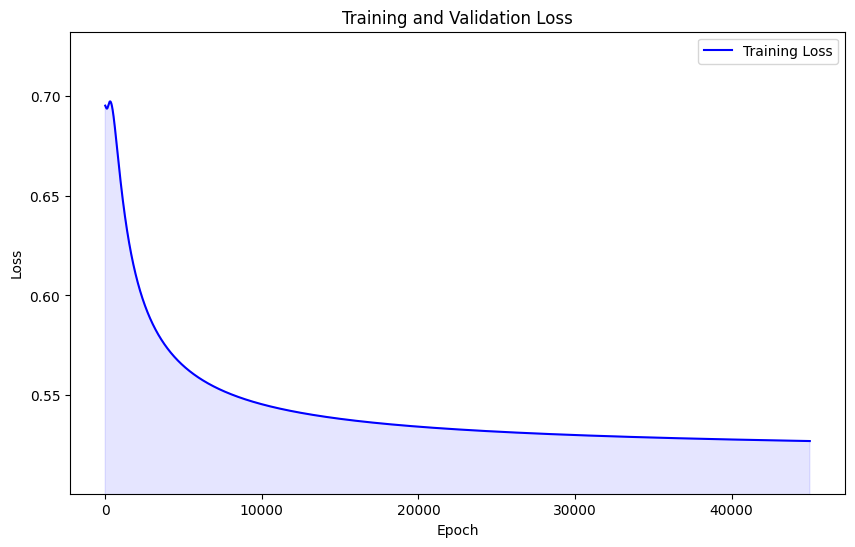

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [805]:
LR, NUM_ITERATIONS = set_classification_parameters()

# For classification
_ = train_model(ce_model, x, y, mode='classification', lr=LR, num_iterations=NUM_ITERATIONS)








In [806]:
# Calculate the Classification Accuracy
y_hat = ce_model(xor_inputs.astype('int'))
print(y_hat)
y_pred = np.argmax(y_hat, axis=1)
accuracy = np.mean(y_pred == xor_targets.squeeze())

print("\nModel Predictions:")
print(y_pred.reshape(-1, 1))

print("\nTarget Values:")
print(xor_targets.astype('int'))

print(f"\nClassification Accuracy: {accuracy:.2f}")

[[0.99364987 0.00635013]
 [0.50567083 0.49432917]
 [0.50566483 0.49433517]
 [0.50001277 0.49998723]]

Model Predictions:
[[0]
 [0]
 [0]
 [0]]

Target Values:
[[0]
 [1]
 [1]
 [0]]

Classification Accuracy: 0.50


### Train XOR as Regression Task

Next, we’ll train the XOR model as a regression task.
After training, we will measure the model’s performance using the **Mean Absolute Difference** between predictions and targets.

**Notes**: 
- Your learning rate (`lr`) must be a positive float.
- The number of iterations (`num_iterations`) you run must be a positive integer that is a multiple of 10, and must also be less than 50,000. 

In [807]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# Set regression hyperparameters for training here - we've given default values - these may not be optimal,
# so you will want to experiment with different values
def set_regression_parameters():
    # YOUR CODE BELOW HERE
    LR = 0.5
    NUM_ITERATIONS = 1
    # YOUR CODE ABOVE HERE
    return LR, NUM_ITERATIONS

<Figure size 640x480 with 0 Axes>

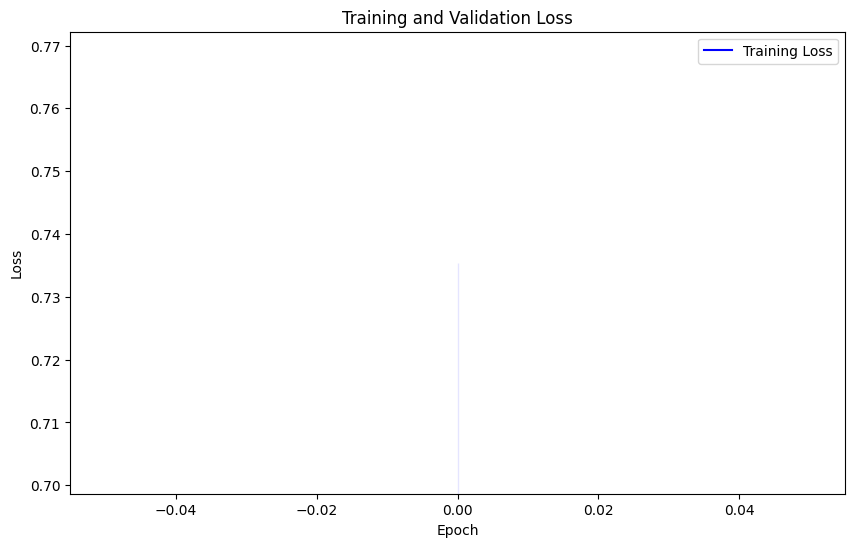

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [808]:
LR, NUM_ITERATIONS = set_regression_parameters()

# For regression
_ = train_model(mse_model, x, y, mode='regression', lr=LR, num_iterations=NUM_ITERATIONS)

In [809]:
y_hat = mse_model(xor_inputs)
y = xor_targets

print("Model Outputs:")
print(np.round(y_hat, decimals=3))

print("\nTarget Values:")
print(y)

mean_difference = np.mean(np.abs(y - y_hat))
print(f"\nMean Absolute Difference (Error): {mean_difference:.6f}")

Model Outputs:
[[ 0.   ]
 [ 0.065]
 [-0.041]
 [-0.001]]

Target Values:
[[0.]
 [1.]
 [1.]
 [0.]]

Mean Absolute Difference (Error): 0.494305


# Grading

You score for this part of the assignment will be out of **50 points**. A more detailed breakdown is as follows: 
- 35 points will be towards implementing all the MicroTorch modules correctly. 
- 15 points will be towards implementing the XOR network in MicroTorch correctly (100% classification accuracy, low MAE). 

There will be sanity checks that will give you a rough idea of how well you are doing. They will be independent test cases that will follow the same score scaling - make sure to check the outputs of those test cases in Gradescope! Performance on these sanity checks is a good indication, however, these tests are not exhaustive and do not guarantee any final score. We'll test your network and module functions on a variety of inputs and seeds. You should test your code thoroughly (feel free to write your own tests, and verify your implementations against PyTorch or TensorFlow). 

For the hidden tests for the XOR problem, we will run your code on various seeds to ensure its consistency. 

# Submission
Upload this notebook with the name `submission.ipynb` file to Gradescope. The autograder will **only** run successfully if your file is named this way. You must ensure that you have removed all print statements from **your** code, or the autograder may fail to run. Excessive print statements will also result in muddled test case outputs, which makes it more difficult to interpret your score.

We've added appropriate comments to the top of certain cells for the autograder to export (`# export`). You do NOT have to do anything (e.g. remove print statements) to cells we have provided - anything related to those have been handled for you. You are responsible for ensuring your own code has no syntax errors or unnecessary print statements. You ***CANNOT*** modify the export comments at the top of the cells, or the autograder will fail to run on your submission.

You should ***not*** add any cells that your code requires to the notebook when submitting. You're welcome to add any code as you need to extra cells when testing, but they will not be graded. Only the provided cells will be graded. As mentioned in the top of the notebook, **any helper functions that you add should be nested within the function that uses them.**

If you encounter any issues with the autograder, please feel free to make a post on Ed Discussion. We highly recommend making a public post to clarify any questions, as it's likely that other students have the same questions as you! If you have a question that needs to be private, please make a private post.
